For the [exercise 2, lesson 4](https://www.udacity.com/course/viewer#!/c-ud359/l-729939275/e-712470090/m-712470091), the goal is to generate another visualization, based on the same data set. As there is some kind of incentive to make something more advanced, I will plot a [ggplot facet](http://ggplot.yhathq.com/docs/facet_grid.html). A faceted plot is as way to display a third and a fourth variable. In this notebook I will plot the number of riderships throughout the day, by day of week and for the 5 crowdiest stations (``unit`` in the data set).

We will use the now usually tools:

In [1]:
%matplotlib inline
import pandas as pd
import pandasql
from ggplot import *
from datetime import *

As for the previous exercise, we will import the data set, rename the columns to use ``pandasql`` and add the week day:

In [2]:
turnstile_weather = pd.read_csv('data/turnstile_data_master_with_weather.csv')
turnstile_weather.is_copy = False

In [3]:
turnstile_weather.rename(columns = lambda x: x.replace(' ', '_').lower(), inplace=True) 

In [4]:
turnstile_weather['week_day'] = turnstile_weather['daten'].map(
            lambda x: datetime.strptime(x, '%Y-%m-%d').weekday())

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


The number of riderships cannot be plotted directly. Most of the time, the number of riderships is given every 4 hours, in some cases starting from 0:00 and in some other cases starting from 1:00. Intermediate values are also sometimes given. To make it consistent, I will aggregate the number of entries by bucket of 4 hours. To make it look nice on the display, the bucket 2 will be fed will all the entries between 0:00 and 3:59. 

In [5]:
def clean_hour(hour):
    if hour < 4:
        hour_bucket = 2
    if hour >= 4 and hour < 8:
        hour_bucket = 6
    if hour >= 8 and hour < 12:
        hour_bucket = 10
    if hour >= 12 and hour < 16:
        hour_bucket = 14
    if hour >= 16 and hour < 20:
        hour_bucket = 18
    if hour >= 20:
        hour_bucket = 22
    return hour_bucket

In [6]:
turnstile_weather['hour_bucket'] = turnstile_weather['hour'].map(clean_hour)

Let's have a quick look at the data set to see the result:

In [7]:
print turnstile_weather[['daten', 'timen', 'hour', 'hour_bucket', 'entriesn_hourly']]

             daten     timen  hour  hour_bucket  entriesn_hourly
0       2011-05-01  01:00:00     1            2                0
1       2011-05-01  05:00:00     5            6              217
2       2011-05-01  09:00:00     9           10              890
3       2011-05-01  13:00:00    13           14             2451
4       2011-05-01  17:00:00    17           18             4400
5       2011-05-01  21:00:00    21           22             3372
6       2011-05-01  01:00:00     1            2                0
7       2011-05-01  05:00:00     5            6               42
8       2011-05-01  09:00:00     9           10               50
9       2011-05-01  13:00:00    13           14              316
10      2011-05-01  17:00:00    17           18              633
11      2011-05-01  21:00:00    21           22              639
12      2011-05-01  00:00:00     0            2                0
13      2011-05-01  04:00:00     4            6                0
14      2011-05-01  12:00

Everything is fine so let's move to the next step, the selection of the top 5 stations (more precisely the ``unit`` field).

In [8]:
q = """
select unit, sum(entriesn_hourly)
from turnstile_weather
group by unit
"""
entries_unit = pandasql.sqldf(q.lower(), locals())

Once aggregated by units, we can select the top 5 units with the ``pandas`` functions ``sort`` and ``head``.

In [9]:
entries_unit_top_5 = entries_unit.sort(columns='sum(entriesn_hourly)', ascending=False).head(5)
unit_top_5 = entries_unit_top_5['unit'].values
print unit_top_5

[u'R170' u'R084' u'R022' u'R033' u'R046']


I will now create a new pandas data set limited to the 5 units from the array above. Note the syntax to select rows from an array.

In [10]:
turnstile_weather_small = turnstile_weather[turnstile_weather['unit'].isin(unit_top_5)]

The data set is not fully clean yet. Since data will be plotted against the week day and the number of week days is variable with the month, we need to fix this bias. As done with the previous exercise, the entries will be added by date, and then averaged by week day.

In [11]:
q = """
select unit, daten, hour_bucket, week_day, sum(entriesn_hourly)
from turnstile_weather_small
group by unit, daten, hour_bucket
"""
entries_unit_hour_bucket = pandasql.sqldf(q.lower(), locals())
entries_unit_hour_bucket.rename(columns={'sum(entriesn_hourly)': 'entriesn_bucket'}, inplace=True)

In [12]:
print entries_unit_hour_bucket

     unit       daten  hour_bucket  week_day  entriesn_bucket
0    R022  2011-05-01            2         6                0
1    R022  2011-05-01            6         6             2120
2    R022  2011-05-01           10         6              603
3    R022  2011-05-01           14         6             3344
4    R022  2011-05-01           18         6             9958
5    R022  2011-05-01           22         6            15283
6    R022  2011-05-02            2         0             6881
7    R022  2011-05-02            6         0              803
8    R022  2011-05-02           10         0             1994
9    R022  2011-05-02           14         0             6598
10   R022  2011-05-02           18         0            12950
11   R022  2011-05-02           22         0            26450
12   R022  2011-05-03            2         1            13143
13   R022  2011-05-03            6         1             7919
14   R022  2011-05-03           10         1             1886
15   R02

We are reading to average the entries by week day, and plot the result.

In [13]:
q = """
select unit, week_day, hour_bucket, avg(entriesn_bucket)
from entries_unit_hour_bucket
group by unit, week_day, hour_bucket
"""
entries_unit_week_day = pandasql.sqldf(q.lower(), locals())

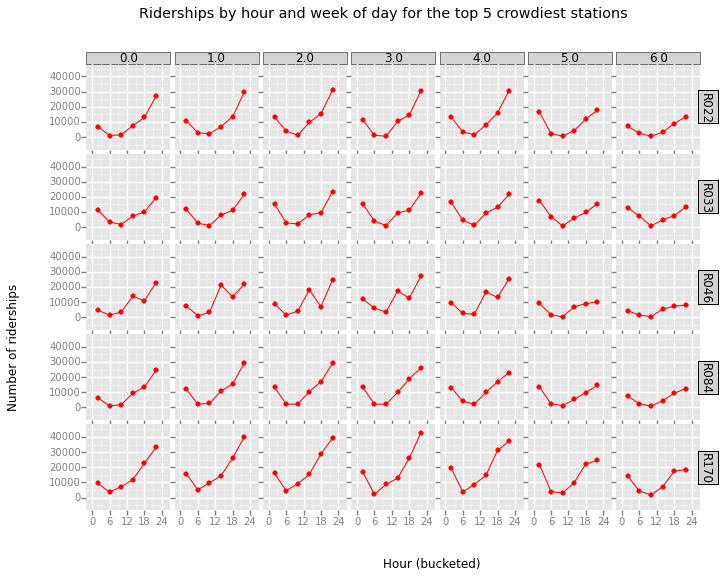

<ggplot: (188900653)>

In [14]:
ggplot(entries_unit_week_day, aes('hour_bucket', 'avg(entriesn_bucket)')) + \
    geom_point(color='red') + geom_line(color='red') + \
    facet_grid('unit', 'week_day') + \
    xlab('Hour (bucketed)') + ylab('Number of riderships') + \
    ggtitle("Riderships by hour and week of day for the top 5 crowdiest stations")

We can see two different patterns. The main one is a low number of riderships around 6 AM, and a high number of riderships in the evening, for the business days. The pattern is similar during the weekend, but with less riderships. This is the pattern for the units ``R022``, ``R033``, ``R084`` and ``R170``. The unit ``R046`` is an exception. There is a peak of riderships between 12 PM and 6 PM. That would be interesting to know which station is behind which unit.